In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize

%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [4]:
history = pd.DataFrame(
    [],
    columns=pd.MultiIndex.from_product([['train', 'validate'], ['logloss', 'accuracy']]),
    dtype='float32'
)

def evaluate_model(clf, slug, xtrain, ytrain, xvalid, yvalid, fit=True):
    global history
    if fit:
        clf.fit(xtrain, ytrain)

    if hasattr(clf, 'decision_function'):
        # print loss values
        df = clf.decision_function(xtrain)
        predictions = np.exp(df) / np.sum(np.exp(df), axis=1, keepdims=True)
        print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
        history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)

        df = clf.decision_function(xvalid)
        predictions = np.exp(df) / np.sum(np.exp(df), axis=1, keepdims=True)
        print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
        history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    else:
        # print loss values
        predictions = clf.predict_proba(xtrain)
        print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))
        history.loc[slug, ('train', 'logloss')] = log_loss(ytrain, predictions)
        predictions = clf.predict_proba(xvalid)
        print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))
        history.loc[slug, ('validate', 'logloss')] = log_loss(yvalid, predictions)
    
    # print accuracy matrix
    predictions = clf.predict(xtrain)
    print('train set')
    print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_, digits=3))
    print('-' * 70)
    predictions = clf.predict(xvalid)
    print('validate set')
    print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

    plot_confusion_matrix(clf, xvalid, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
    plt.grid(False)
    
    history.loc[slug, ('train', 'accuracy')] = balanced_accuracy_score(ytrain, clf.predict(xtrain))
    history.loc[slug, ('validate', 'accuracy')] = balanced_accuracy_score(yvalid, clf.predict(xvalid))

    return clf

## 训练样本拆分

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(
    train.text.values, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True
)
print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


## 载入GloVec词向量

In [6]:
with open('./data/glove.compress.embeddings.pickle', 'rb') as f:
    embeddings_index = pickle.load(f)

with open('./data/glove.compress.vocabulary.pickle', 'rb') as f:
    vocabulary = pickle.load(f)


## 特征提取

句子 --> 分词 --> 各词特征向量 --> 由词特征向量计算句向量

In [7]:
def sentence2vec(sentence, stopwords=set()):
    x = np.zeros(len(embeddings_index['a']))
    for w in word_tokenize(sentence):
        if w in stopwords:
            print('stopwords')
            continue
        if w not in embeddings_index:
            continue
        x += embeddings_index[w]
    return preprocessing.normalize([x])[0]

In [8]:
def sentence_array2vec(a, stopwords=set()):
    out = np.empty((len(a), 300))
    for idx, s in enumerate(a):
        out[idx] = sentence2vec(s)
    return out

In [9]:
xtrain_glove_ns = sentence_array2vec(xtrain)
xvalid_glove_ns = sentence_array2vec(xvalid)

In [10]:
svd = TruncatedSVD()
scl = preprocessing.StandardScaler()
svc = SVC(class_weight='balanced', probability=True)

clf = Pipeline([
    ('svd', svd),
    ('scl', scl),
    ('svc', svc),
])

In [11]:
param_grid = {
    'svd__n_components' : [100, 120, 180],
    'svc__C': np.power(10, np.linspace(np.log10(1e-2), np.log10(1e2), 4)),
    'svc__kernel': ['rbf', 'poly']
}

In [12]:
model = GridSearchCV(
    estimator=clf, param_grid=param_grid,
    scoring=['neg_log_loss', 'accuracy'], refit='neg_log_loss',
    verbose=10, n_jobs=-1
)

## 训练

In [13]:
xsearch, _, ysearch, _ = train_test_split(xtrain_glove_ns, ytrain, random_state=42, stratify=ytrain, train_size=0.2)
print(xsearch.shape)

(3524, 300)


In [14]:
model.fit(xsearch, ysearch)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=Pipeline(steps=[('svd', TruncatedSVD()),
                                       ('scl', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                         'svc__kernel': ['rbf', 'poly'],
                         'svd__n_components': [100, 120, 180]},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=10)

In [15]:
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.684
Best parameters set:
	svc__C: 4.6415888336127775
	svc__kernel: 'rbf'
	svd__n_components: 120


train set: logloss: 0.325
valid set: logloss: 0.697
train set
              precision    recall  f1-score   support

         EAP      0.988     0.979     0.983      7110
         HPL      0.986     0.988     0.987      5071
         MWS      0.978     0.988     0.983      5440

    accuracy                          0.984     17621
   macro avg      0.984     0.985     0.984     17621
weighted avg      0.984     0.984     0.984     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.755     0.797     0.776       790
         HPL      0.764     0.734     0.749       564
         MWS      0.730     0.704     0.717       604

    accuracy                          0.750      1958
   macro avg      0.750     0.745     0.747      1958
weighted avg      0.750     0.750     0.750      1958



Pipeline(steps=[('svd', TruncatedSVD(n_components=120)),
                ('scl', StandardScaler()),
                ('svc',
                 SVC(C=4.6415888336127775, class_weight='balanced',
                     probability=True))])

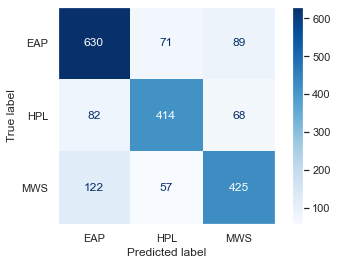

In [16]:
evaluate_model(
    model.best_estimator_,
    'Best Estimator',
    xtrain_glove_ns, ytrain,
    xvalid_glove_ns, yvalid,
)

In [17]:
history

train           validate          
                 logloss accuracy   logloss  accuracy
Best Estimator  0.324935  0.98489  0.697216  0.745051